<a href="https://colab.research.google.com/github/souvik25162/Automated-feature-engineering/blob/master/Loan_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score
import featuretools as ft

In [5]:
from google.colab import files
uploaded=files.upload()
df=pd.read_excel('loan.xlsx')
df.head(7)

Saving loan.xlsx to loan (1).xlsx


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [6]:
df.shape

(614, 13)

In [ ]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
df['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

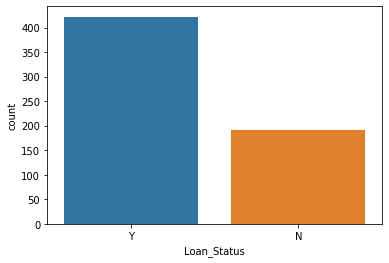

In [ ]:
sns.countplot(df['Loan_Status'],label='count')

In [ ]:
df.dtypes


Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [ ]:
from sklearn.preprocessing import LabelEncoder
LabelEncoder_Y= LabelEncoder()
for column in df.columns:
  if df[column].dtype == np.number:
    continue
  else:
    df[column]=LabelEncoder().fit_transform(df[column])  

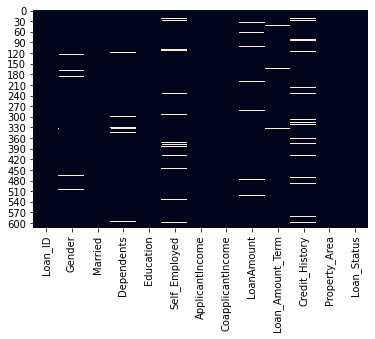

In [7]:
sns.heatmap(df.isnull(),cbar=False)

In [8]:
df=df.drop(columns=['Self_Employed','Gender','Married','Dependents'],axis=1)

In [9]:
from sklearn.preprocessing import LabelEncoder
labelencoder_y=LabelEncoder()
df['Loan_Status']=labelencoder_y.fit_transform(df['Loan_Status'].values)
df['Education']=labelencoder_y.fit_transform(df['Education'].values)
df['Property_Area']=labelencoder_y.fit_transform(df['Property_Area'].values)

In [10]:
df['LoanAmount']=df['LoanAmount'].replace(np.nan,np.mean(df['LoanAmount']))
df['Loan_Amount_Term']=df['Loan_Amount_Term'].replace(np.nan,np.mean(df['Loan_Amount_Term']))
df['Credit_History']=df['Credit_History'].replace(np.nan,0)

In [11]:
X=df.drop(columns=['Loan_ID','Loan_Status'],axis=1)
Y=df['Loan_Status']

In [12]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)

In [13]:
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

In [14]:
def models(X_train,Y_train):
    from sklearn.linear_model import LogisticRegression
    lreg=LogisticRegression()
    lreg.fit(X_train,Y_train)
    
    from sklearn.tree import DecisionTreeClassifier
    tree=DecisionTreeClassifier(random_state=0)
    tree.fit(X_train,Y_train)
    
    from sklearn.ensemble import RandomForestClassifier
    rf=RandomForestClassifier(n_estimators=100,criterion='entropy')
    rf.fit(X_train,Y_train)
    
    print('[0]logistic reg accuracy:',lreg.score(X_train,Y_train))
    print('[1]Decision tree accuracy:',tree.score(X_train,Y_train))
    print('[2]random forest accuracy:',rf.score(X_train,Y_train))

In [15]:
model=models(X_train,Y_train)

[0]logistic reg accuracy: 0.7657841140529531
[1]Decision tree accuracy: 1.0
[2]random forest accuracy: 1.0


In [16]:
from sklearn.linear_model import LogisticRegression
lreg=LogisticRegression()
lreg.fit(X_train,Y_train)    

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
predictions=lreg.predict(X_test)

In [19]:
print(accuracy_score(predictions,Y_test))
print(f1_score(predictions,Y_test))

0.7886178861788617
0.8617021276595744


In [20]:
es=ft.EntitySet(id='loan')

In [21]:
q=df['Loan_ID']
X2=pd.concat([q,X],axis=1)

In [22]:
X2.head()

,Loan_ID,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001002,0,5849,0.0,146.412162,360.0,1.0,2
1,LP001003,0,4583,1508.0,128.000000,360.0,1.0,0
2,LP001005,0,3000,0.0,66.000000,360.0,1.0,2
3,LP001006,1,2583,2358.0,120.000000,360.0,1.0,2
4,LP001008,0,6000,0.0,141.000000,360.0,1.0,2


In [23]:
es= es.entity_from_dataframe(entity_id = 'customer', dataframe =X2, index ='Loan_ID')

In [24]:
es = es.normalize_entity(base_entity_id='customer', new_entity_id='LoanAmount', index='LoanAmount')
es = es.normalize_entity(base_entity_id='customer', new_entity_id='ApplicantIncome', index='ApplicantIncome')
es = es.normalize_entity(base_entity_id='customer', new_entity_id='CoapplicantIncome', index='CoapplicantIncome')
es = es.normalize_entity(base_entity_id='customer', new_entity_id='Loan_Amount_Term', index='Loan_Amount_Term')


In [25]:
default_agg_primitives =  ["sum", "max", "min", "mean", "count"]


# DFS with specified primitive
feature_names = ft.dfs(entityset = es, target_entity = 'customer',
                       agg_primitives=default_agg_primitives, 
                       max_depth = 2, features_only=True)

print('%d Total Features' % len(feature_names))

59 Total Features


In [26]:
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'customer',
                                       agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True)

pd.options.display.max_columns = 1700
feature_matrix.head(10)

Built 59 features
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,LoanAmount.SUM(customer.Education),LoanAmount.SUM(customer.Credit_History),LoanAmount.SUM(customer.Property_Area),LoanAmount.MAX(customer.Education),LoanAmount.MAX(customer.Credit_History),LoanAmount.MAX(customer.Property_Area),LoanAmount.MIN(customer.Education),LoanAmount.MIN(customer.Credit_History),LoanAmount.MIN(customer.Property_Area),LoanAmount.MEAN(customer.Education),LoanAmount.MEAN(customer.Credit_History),LoanAmount.MEAN(customer.Property_Area),LoanAmount.COUNT(customer),ApplicantIncome.SUM(customer.Education),ApplicantIncome.SUM(customer.Credit_History),ApplicantIncome.SUM(customer.Property_Area),ApplicantIncome.MAX(customer.Education),ApplicantIncome.MAX(customer.Credit_History),ApplicantIncome.MAX(customer.Property_Area),ApplicantIncome.MIN(customer.Education),ApplicantIncome.MIN(customer.Credit_History),ApplicantIncome.MIN(customer.Property_Area),ApplicantIncome.MEAN(customer.Education),ApplicantIncome.MEAN(customer.Credit_History),ApplicantIncome.MEAN(customer.Property_Area),ApplicantIncome.COUNT(customer),CoapplicantIncome.SUM(customer.Education),CoapplicantIncome.SUM(customer.Credit_History),CoapplicantIncome.SUM(customer.Property_Area),CoapplicantIncome.MAX(customer.Education),CoapplicantIncome.MAX(customer.Credit_History),CoapplicantIncome.MAX(customer.Property_Area),CoapplicantIncome.MIN(customer.Education),CoapplicantIncome.MIN(customer.Credit_History),CoapplicantIncome.MIN(customer.Property_Area),CoapplicantIncome.MEAN(customer.Education),CoapplicantIncome.MEAN(customer.Credit_History),CoapplicantIncome.MEAN(customer.Property_Area),CoapplicantIncome.COUNT(customer),Loan_Amount_Term.SUM(customer.Education),Loan_Amount_Term.SUM(customer.Credit_History),Loan_Amount_Term.SUM(customer.Property_Area),Loan_Amount_Term.MAX(customer.Education),Loan_Amount_Term.MAX(customer.Credit_History),Loan_Amount_Term.MAX(customer.Property_Area),Loan_Amount_Term.MIN(customer.Education),Loan_Amount_Term.MIN(customer.Credit_History),Loan_Amount_Term.MIN(customer.Property_Area),Loan_Amount_Term.MEAN(customer.Education),Loan_Amount_Term.MEAN(customer.Credit_History),Loan_Amount_Term.MEAN(customer.Property_Area),Loan_Amount_Term.COUNT(customer)
Loan_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
LP001002,0,5849,0.0,146.412162,360.0,1.0,2,7,17.0,27,1,1.0,2,0,0.0,0,0.318182,0.772727,1.227273,22,0,1.0,2,0,1.0,2,0,1.0,2,0.000000,1.000000,2.000000,1,52,213.0,296,1,1.0,2,0,0.0,0,0.190476,0.78022,1.084249,273,101,404.0,512,1,1.0,2,0,0.0,0,0.197266,0.789062,1.0,512
LP001003,0,4583,1508.0,128.000000,360.0,1.0,0,2,9.0,14,1,1.0,2,0,0.0,0,0.181818,0.818182,1.272727,11,0,5.0,3,0,1.0,1,0,0.0,0,0.000000,0.833333,0.500000,6,0,1.0,0,0,1.0,0,0,1.0,0,0.000000,1.00000,0.000000,1,101,404.0,512,1,1.0,2,0,0.0,0,0.197266,0.789062,1.0,512
LP001005,0,3000,0.0,66.000000,360.0,1.0,2,2,3.0,2,1,1.0,2,0,0.0,0,0.500000,0.750000,0.500000,4,1,2.0,5,1,1.0,2,0,0.0,1,0.333333,0.666667,1.666667,3,52,213.0,296,1,1.0,2,0,0.0,0,0.190476,0.78022,1.084249,273,101,404.0,512,1,1.0,2,0,0.0,0,0.197266,0.789062,1.0,512
LP001006,1,2583,2358.0,120.000000,360.0,1.0,2,6,17.0,19,1,1.0,2,0,0.0,0,0.300000,0.850000,0.950000,20,2,3.0,4,1,1.0,2,0,0.0,0,0.500000,0.750000,1.000000,4,1,1.0,2,1,1.0,2,1,1.0,2,1.000000,1.00000,2.000000,1,101,404.0,512,1,1.0,2,0,0.0,0,0.197266,0.789062,1.0,512
LP001008,0,6000,0.0,141.000000,360.0,1.0,2,0,2.0,2,0,1.0,2,0,1.0,0,0.000000,1.000000,1.000000,2,0,4.0,6,0,1.0,2,0,0.0,0,0.000000,0.666667,1.000000,6,52,213.0,296,1,1.0,2,0,0.0,0,0.190476,0.78022,1.084249,273,101,404.0,512,1,1.0,2,0,0.0,0,0.197266,0.789062,1.0,512
LP001011,0,5417,4196.0,267.000000,360.0,1.0,2,0,1.0,2,0,1.0,2,0,1.0,2,0.000000,1.000000,2.000000,1,0,2.0,6,0,1.0,2,0,0.0,2,0.000000,0.666667,2.000000,3,0,1.0,2,0,1.0,2,0,1.0,2,0.000000,1.00000,2.000000,1,101,404.0,512,1,1.0,2,0,0.0,0,0.197266,0.789062,1.0,512
LP001013,1,2333,1516.0,95.000000,360.0,1.0,2,4,7.0,9,1,1.0,2,0,0.0,0,0.444

In [27]:
feature_matrix = feature_matrix.reset_index()

print('Saving features')
feature_matrix.to_csv('new_matrix.csv', index = False)

Saving features


In [28]:
X3=pd.read_csv('new_matrix.csv')
X_new=X3.drop(columns=['Loan_ID'],axis=1)

In [29]:
corr=X_new.corr().abs()

In [30]:
upper=corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
threshold=0.7
collinear_features=[column for column in upper.columns if any(upper[column]>threshold)]

In [31]:
X=X_new.drop(X_new[collinear_features],axis=1)

In [32]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)

In [33]:
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

In [34]:
def models(X_train,Y_train):
    from sklearn.linear_model import LogisticRegression
    lreg=LogisticRegression()
    lreg.fit(X_train,Y_train)
    
    from sklearn.tree import DecisionTreeClassifier
    tree=DecisionTreeClassifier(random_state=0)
    tree.fit(X_train,Y_train)
    
    from sklearn.ensemble import RandomForestClassifier
    rf=RandomForestClassifier(n_estimators=100,criterion='entropy')
    rf.fit(X_train,Y_train)
    
    print('[0]logistic reg accuracy:',lreg.score(X_train,Y_train))
    print('[1]Decision tree accuracy:',tree.score(X_train,Y_train))
    print('[2]random forest accuracy:',rf.score(X_train,Y_train))

In [35]:
model=models(X_train,Y_train)

[0]logistic reg accuracy: 0.7739307535641547
[1]Decision tree accuracy: 1.0
[2]random forest accuracy: 1.0


In [36]:
from sklearn.linear_model import LogisticRegression
lreg=LogisticRegression()
lreg.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
predictions2=lreg.predict(X_test)

In [38]:
f1_score(predictions2,Y_test)

0.870967741935484

In [39]:
accuracy_score(predictions2,Y_test)

0.8048780487804879